# Exercise 3: Convolutional Neural Networks

Gruppo Stocafisici: Edoardo Antonaci, Angelica Foroni, Francesco Mazza, Leonardo Salicari.

1. Experiment with different architectures (which was left as an open point when “NCONV”
variable was introduced), in particular try at least another version where only one
convolutional layer is introduced instead of two, and where any number of dense layers may
be used, with the global constraint of using a network with at most 600 trainable parameters.
The filter length in the second convolutional layer may be shorter.
Is the number of parameters scaling more quickly by adding Dense layers or Conv1D
layers?
Check which configuration works better by comparing the performances quantitatively.
2. Visualize the “confusion matrix” (look for similar examples in the material available or by
googling)
3. With two convolutional layers, plot also the weights of the second layer and try to see if
regularization may improve the performances by varying the parameter lambda of the L1 or
of the L2 regularization; see lambda in eqs.(43) and (52) in the review. There is also a mixed
version (l1_l2?) that can be tried. Is any value of lambda good? Is there any intermediate
value where the performances of the network are better? Is there any improvement in the
visualization and understanding of the weights in the filters? Note that the regularization we
introduced acts on the w’s, not on the biases. One can also try the equivalent procedure for
biases or for the output of the relu units (see Keras doc.), if there is any reason for
suspecting that it may help. In our case, the logic was to let the weights of the filters go to
zero if not needed, hence that kind of regularization was selected.
4. By reducing the signal-to-noise ratio, namely the amplitude of the external signal in the data
(A) with respect to the step typical size of the jump process, check where the network starts
to fail discriminating the categories.

### Loading dataset
We are going to use the dataset generated during the lecture

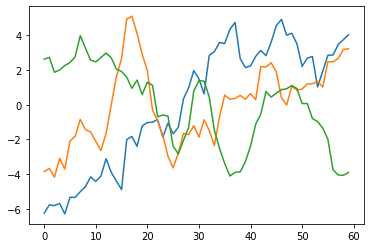

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

name = '_ts_L60_Z12_A12_DX50_bias5_N10000.csv'
xname = 'DATA/x' + name
yname = 'DATA/y' + name

# Dataset
x = np.loadtxt(xname, delimiter=',', dtype=float)
N = x.shape[0]
L = x.shape[1]

# Labels
categ = np.loadtxt(yname, delimiter=',', dtype=int)
n_class = 3
y = np.zeros((N, n_class ))
for i in range(N):
    y[i][categ[i]] = 1.

# Removing avg and scaling data
x_avg = np.mean(x, axis=1).reshape(N,1) # average over sample (i.e. over rows)
x = (x - x_avg)/100 # one line to remove avg and scale; faster than a for loop
    
# Training and Validation
# Note, these are view, not copies
train_frac = .8
N_train = int(N*train_frac)
x_train = x[0:N_train,:]
y_train = y[0:N_train,:]
x_val = x[N_train:,:]
y_val = y[N_train:,:]

# Plotting some data
for k in range(3):
    plt.plot(x_train[k])
    
# Reshape for Keras
# Hence adding an extra dim wich correspond to the depth 
x_train = x_train.reshape(x_train.shape[0],L,1)
x_val = x_val.reshape(x_val.shape[0],L,1)

input_size = (L,1)

## 1: CNN with different topologies

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils.layer_utils import count_params # for count number of parameters
from keras.losses import categorical_crossentropy
from keras import initializers, regularizers
from keras import optimizers

def create_model(NCONV=1, n_dense_layers=1, kernel_size_diff=1, summary=False):
    ''' 
    Creates a CNN with different topologies by changing NCONV 
    Returns the model and the number of trainable parameters
    
    n_dense_layers = number of dense layers in the CNN
    kernel_size_diff = (kernel_size first Conv layer) - (kernel_size second Conv layer)
    summary = print model.summary()
    
    NCONV == 1:
        From baiesi lecture
        Conv -> AvgPadding -> Conv -> Fattern -> Dense*(n_dense_layers) -> Dense (output)
    NCONV == 2: 
        Only one Conv layer
        Conv -> AvgPadding -> Fattern -> Dense*(n_dense_layers) -> Dense (output)
        
    '''
    if n_dense_layers < 1:
        raise('n_dense_layer must be int and >= 1')
        
    # Defining regulirizer
    reg = regularizers.l1(0.1)
    # Used to initialize kernel 
    init = initializers.RandomNormal(mean = 0,
                                   stddev = .05)
    model = Sequential()

    if NCONV == 1:
        model.add( Conv1D(filters=5,
                          kernel_size = 11,                              
                          kernel_initializer = init,
                          kernel_regularizer = reg,
                          activation = 'relu',
                          input_shape = input_size
                         ) )
        model.add( AveragePooling1D(5) ) # max pooling windows' size
        model.add( Conv1D(filters=5, 
                          kernel_size = 11 - kernel_size_diff, 
                          activation = 'relu',) )
        model.add( Flatten() )
        for _ in range(n_dense_layers): # variable number of layers
            model.add( Dense(10, activation='relu') )
        model.add( Dropout(0.2) )
        
    elif NCONV == 2:
        model.add( Conv1D(filters=5,
                          kernel_size = 11,                              
                          kernel_initializer = init,
                          kernel_regularizer = reg,
                          activation = 'relu',
                          input_shape = input_size
                         ) )
        model.add( AveragePooling1D(5) ) # max pooling windows' size
        model.add( Flatten() )
        for _ in range(n_dense_layers): # variable number of layers
            model.add( Dense(10, activation='relu') )
        model.add( Dropout(0.2) )
    else:
        raise('NCONV must be an int: 1 or 2')
        
    # Output layer
    model.add(Dense(n_class, activation='softmax')) 
    
    # print model's details
    if summary: print(model.summary())
    # Number of trainable parameters
    trainable_count = count_params(model.trainable_weights)
    
    # Compiling model
    opt = optimizers.Nadam()
    model.compile( loss = categorical_crossentropy,
              optimizer = opt,
              metrics = ['accuracy'])
    
    return (model, trainable_count)

Using TensorFlow backend.


### Training and test performance

 Is the number of parameters scaling more quickly by adding Dense layers or Conv1D layers?

Text(0, 0.5, '# of trainable parameters')

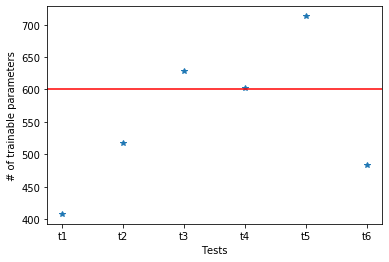

In [3]:
# Define dicts to test different topologies
# t1 == test 1
t1 = dict(NCONV = 1, n_dense_layers = 1, kernel_size_diff = 1)
t2 = dict(NCONV = 1, n_dense_layers = 2, kernel_size_diff = 1)
t3 = dict(NCONV = 1, n_dense_layers = 3, kernel_size_diff = 1)
t4 = dict(NCONV = 2, n_dense_layers = 1, kernel_size_diff = 1)
t5 = dict(NCONV = 2, n_dense_layers = 2, kernel_size_diff = 1)
t6 = dict(NCONV = 1, n_dense_layers = 1, kernel_size_diff = 4)

# Array with tests
tests = [t1,t2,t3,t4,t5,t6]
# Array with names for plotting porpuses
tests_plot = ['t1','t2','t3','t4','t5','t6']
# Array to save # of parameters
params = [0] * len(tests)

for idx,t in enumerate(tests):
    _, params[idx] = create_model(**t, summary=False) # **t is the syntax to 'unpack' values from dict
    
# Visualising number of parameters
plt.close()
plt.plot(tests_plot, params, '*')
plt.axhline(y=600, color='red') # line of 600 parameters
plt.xlabel('Tests')
plt.ylabel('# of trainable parameters')

#### Comment
It's seems like that removing a `Conv1D` layer the number of trainable parameters grows. Looking at the summary of the models, this apparent contradiction seems to be solve by the fact that in the case of 2 convolutional layers the `output size` of the layer's output is smaller compared to the model with only one convolutional layer.

Than, the fully connected layers (the `Dense` one) han a number of trainable parameters related to the number of weights and biases which grows quickly with the `output size` of the previous layer. Hence, the one-convolutional-layer model has more parameters due to its bigger output given to the fully connected layer.

For more info, use the option `summary=True` in the `create_model()` function's call.

### Performance comparison
It'll be trained models relative to configurations `t2`, `t4` and `t6`


In [4]:
model2, _ = create_model(**t2)
model4, _ = create_model(**t4)
model6, _ = create_model(**t6)

# Training
batch_size = 250
epochs = 100

fit2 = model2.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_val,y_val),
                verbose = 2,
                shuffle = True)
fit4 = model4.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_val,y_val),
                verbose = 2,
                shuffle = True)
fit6 = model6.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_val,y_val),
                verbose = 2,
                shuffle = True)

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 3s - loss: 1.1868 - accuracy: 0.3562 - val_loss: 1.1178 - val_accuracy: 0.3895
Epoch 2/100
 - 1s - loss: 1.1055 - accuracy: 0.3766 - val_loss: 1.1011 - val_accuracy: 0.3535
Epoch 3/100
 - 1s - loss: 1.0785 - accuracy: 0.4629 - val_loss: 1.0410 - val_accuracy: 0.5090
Epoch 4/100
 - 1s - loss: 1.0101 - accuracy: 0.5303 - val_loss: 1.0555 - val_accuracy: 0.4825
Epoch 5/100
 - 1s - loss: 0.9457 - accuracy: 0.5592 - val_loss: 0.9185 - val_accuracy: 0.5895
Epoch 6/100
 - 1s - loss: 0.9102 - accuracy: 0.5784 - val_loss: 0.9100 - val_accuracy: 0.5780
Epoch 7/100
 - 1s - loss: 0.8848 - accuracy: 0.5809 - val_loss: 0.9046 - val_accuracy: 0.5675
Epoch 8/100
 - 1s - loss: 0.8587 - accuracy: 0.5991 - val_loss: 0.8400 - val_accuracy: 0.6020
Epoch 9/100
 - 1s - loss: 0.8409 - accuracy: 0.6100 - val_loss: 0.8375 - val_accuracy: 0.6180
Epoch 10/100
 - 1s - loss: 0.8396 - accuracy: 0.6164 - val_loss: 0.8263 - val_accuracy: 0.6225
Epoch 11/10

Epoch 87/100
 - 1s - loss: 0.4245 - accuracy: 0.8705 - val_loss: 0.4513 - val_accuracy: 0.8690
Epoch 88/100
 - 1s - loss: 0.4188 - accuracy: 0.8708 - val_loss: 0.4096 - val_accuracy: 0.8705
Epoch 89/100
 - 1s - loss: 0.4401 - accuracy: 0.8610 - val_loss: 0.4792 - val_accuracy: 0.8575
Epoch 90/100
 - 1s - loss: 0.4293 - accuracy: 0.8655 - val_loss: 0.4484 - val_accuracy: 0.8630
Epoch 91/100
 - 1s - loss: 0.4250 - accuracy: 0.8683 - val_loss: 0.4225 - val_accuracy: 0.8685
Epoch 92/100
 - 1s - loss: 0.4258 - accuracy: 0.8656 - val_loss: 0.4009 - val_accuracy: 0.8815
Epoch 93/100
 - 1s - loss: 0.4378 - accuracy: 0.8655 - val_loss: 0.4058 - val_accuracy: 0.8775
Epoch 94/100
 - 1s - loss: 0.4686 - accuracy: 0.8529 - val_loss: 0.4053 - val_accuracy: 0.8810
Epoch 95/100
 - 1s - loss: 0.4218 - accuracy: 0.8674 - val_loss: 0.4070 - val_accuracy: 0.8725
Epoch 96/100
 - 1s - loss: 0.4178 - accuracy: 0.8683 - val_loss: 0.4157 - val_accuracy: 0.8775
Epoch 97/100
 - 1s - loss: 0.4199 - accuracy: 0.87

Epoch 73/100
 - 0s - loss: 0.6360 - accuracy: 0.7681 - val_loss: 0.6008 - val_accuracy: 0.8155
Epoch 74/100
 - 0s - loss: 0.6316 - accuracy: 0.7703 - val_loss: 0.5936 - val_accuracy: 0.8095
Epoch 75/100
 - 0s - loss: 0.6343 - accuracy: 0.7656 - val_loss: 0.5951 - val_accuracy: 0.8060
Epoch 76/100
 - 0s - loss: 0.6374 - accuracy: 0.7670 - val_loss: 0.5989 - val_accuracy: 0.8125
Epoch 77/100
 - 0s - loss: 0.6307 - accuracy: 0.7660 - val_loss: 0.5874 - val_accuracy: 0.8185
Epoch 78/100
 - 0s - loss: 0.6377 - accuracy: 0.7616 - val_loss: 0.5987 - val_accuracy: 0.7990
Epoch 79/100
 - 0s - loss: 0.6248 - accuracy: 0.7715 - val_loss: 0.5962 - val_accuracy: 0.8060
Epoch 80/100
 - 0s - loss: 0.6258 - accuracy: 0.7694 - val_loss: 0.5898 - val_accuracy: 0.8100
Epoch 81/100
 - 0s - loss: 0.6247 - accuracy: 0.7725 - val_loss: 0.5844 - val_accuracy: 0.8165
Epoch 82/100
 - 0s - loss: 0.6351 - accuracy: 0.7613 - val_loss: 0.5970 - val_accuracy: 0.8145
Epoch 83/100
 - 0s - loss: 0.6270 - accuracy: 0.76

Epoch 59/100
 - 1s - loss: 0.5349 - accuracy: 0.8304 - val_loss: 0.4931 - val_accuracy: 0.8440
Epoch 60/100
 - 1s - loss: 0.5248 - accuracy: 0.8253 - val_loss: 0.4907 - val_accuracy: 0.8475
Epoch 61/100
 - 1s - loss: 0.5220 - accuracy: 0.8298 - val_loss: 0.4908 - val_accuracy: 0.8435
Epoch 62/100
 - 1s - loss: 0.5285 - accuracy: 0.8255 - val_loss: 0.4924 - val_accuracy: 0.8415
Epoch 63/100
 - 1s - loss: 0.5222 - accuracy: 0.8303 - val_loss: 0.5083 - val_accuracy: 0.8390
Epoch 64/100
 - 1s - loss: 0.5271 - accuracy: 0.8286 - val_loss: 0.4914 - val_accuracy: 0.8445
Epoch 65/100
 - 1s - loss: 0.5189 - accuracy: 0.8306 - val_loss: 0.4891 - val_accuracy: 0.8435
Epoch 66/100
 - 1s - loss: 0.5215 - accuracy: 0.8311 - val_loss: 0.4861 - val_accuracy: 0.8450
Epoch 67/100
 - 1s - loss: 0.5130 - accuracy: 0.8311 - val_loss: 0.4866 - val_accuracy: 0.8420
Epoch 68/100
 - 1s - loss: 0.5179 - accuracy: 0.8331 - val_loss: 0.4819 - val_accuracy: 0.8460
Epoch 69/100
 - 1s - loss: 0.5061 - accuracy: 0.83

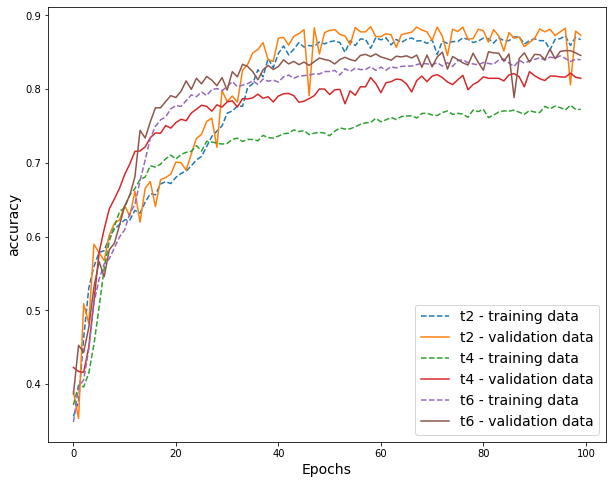

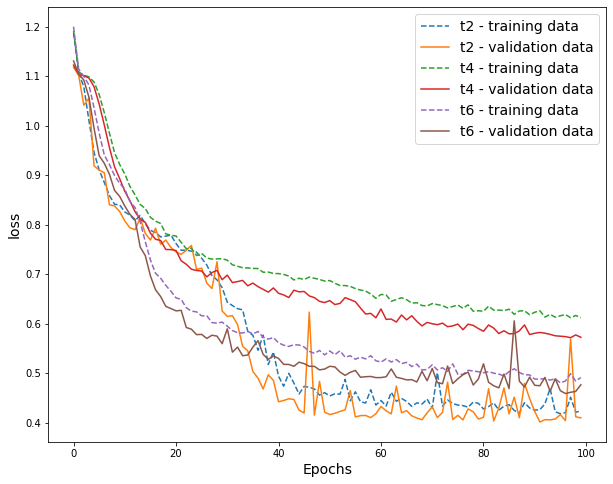

In [5]:
# Grafical comparison

fits = [fit2,fit4,fit6]

plt.close()

# Accuracy
plt.figure(figsize=(10,8))
for fit, test in zip(fits,tests_plot[1::2]):
    
    plt.plot(fit.history['accuracy'], '--',
            label = test + ' - training data')
    
    plt.plot(fit.history['val_accuracy'],
            label = test + ' - validation data') 

fontsize = 14
plt.ylabel('accuracy', fontsize=fontsize)
plt.xlabel('Epochs', fontsize=fontsize)
plt.legend(loc='lower right', fontsize=fontsize)    
plt.show()

# Loss
plt.figure(figsize=(10,8))
for fit, test in zip(fits,tests_plot[1::2]):
    
    plt.plot(fit.history['loss'], '--',
            label = test + ' - training data')
    
    plt.plot(fit.history['val_loss'],
            label = test + ' - validation data') 

fontsize = 14
plt.ylabel('loss', fontsize=fontsize)
plt.xlabel('Epochs', fontsize=fontsize)
plt.legend(loc='upper right', fontsize=fontsize)    
plt.show()

#### Comment
From the learning process, it seems that the `t2` model, the one with 2 convolutional layers and 2 fully connected layers (recall, it has less parameters than `t4`) is the one performing better in the long run, having an accuracy greater that the other models!

The fastest to learn is `t4` related to 1 convolutional layer and 1 fully connected layer but is the worst in the long run. While `t6`, which is like the one used during lessons `3_0X`, stays in the middle.

## 2: Confusion Matrix

In [38]:
from sklearn.metrics import classification_report, confusion_matrix

# Uncomment to have a look at the test (val) data one more time:
#print('x, of shape {}: \n'.format(x_val.shape), x_val, '\n')
#print('y, of shape {}: \n'.format(y.shape), y_val, '\n')

y_pred = model2.predict(x_val, batch_size = batch_size)
print('The predicted values are:\n', y_pred)

The predicted values are:
 [[6.25147135e-04 1.27721755e-02 9.86602664e-01]
 [5.72974384e-01 2.22569361e-01 2.04456270e-01]
 [7.74605423e-02 9.02763784e-01 1.97756588e-02]
 ...
 [4.50674333e-02 9.50493932e-01 4.43866197e-03]
 [6.95718161e-04 1.49909395e-03 9.97805178e-01]
 [8.24660242e-01 1.50038436e-01 2.53012776e-02]]


In order to compute the confusion matrix, we feed to the confusion_matrix function the index of the maximum value for each row, both for the true labels and for the predicted ones. That index corresponds, moreover, to the wanted category (0 = no signal, 1 = positive signal, 2 = negative signal)

In [43]:
confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))

array([[582,  38,  47],
       [ 50, 558,  58],
       [ 40,  21, 606]])